In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as graph
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, Dropout, Conv2D, MaxPool2D, Flatten
from keras.optimizers import Adam
from keras.losses import categorical_crossentropy
from keras.callbacks import TensorBoard
from IPython.display import display

%matplotlib inline

def plot_number(xi, yi=''):
    graph.figure(figsize=(1, 1))
    graph.title('{}'.format(yi))
    graph.imshow(xi.reshape(28, 28), cmap='Greys')
    graph.grid(False)
    graph.show()

Using TensorFlow backend.


In [2]:
data = pd.read_csv('data/kaggle_mnist/train.csv')
print(data.info())

y = data.pop('label').values
x = data.values

print(y.shape, x.shape)
print(y[:5])

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42000 entries, 0 to 41999
Columns: 785 entries, label to pixel783
dtypes: int64(785)
memory usage: 251.5 MB
None
(42000,) (42000, 784)
[1 0 1 4 0]


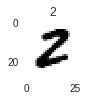

In [3]:
pos = np.random.randint(0, len(y))
plot_number(x[pos, :], y[pos])

# Train Model

(29400, 784) (12600, 784) (29400, 10) (12600, 10)


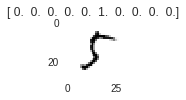

(29400, 28, 28, 1) (12600, 28, 28, 1) (29400, 10) (12600, 10)


In [4]:
# Encode
y_onehot = OneHotEncoder(sparse=False).fit_transform(y.reshape(-1, 1))
x_minmax = x / 255

# Train Test Split
x_train, x_val, y_train, y_val = train_test_split(x_minmax, y_onehot, test_size=0.3)
print(x_train.shape, x_val.shape, y_train.shape, y_val.shape)

plot_number(x_train[0, :], y_train[0, :])

x_train, x_val = x_train.reshape(len(x_train), 28, 28, 1), x_val.reshape(len(x_val), 28, 28, 1)
print(x_train.shape, x_val.shape, y_train.shape, y_val.shape)

In [5]:
# Initialise Type
model = Sequential()

# Tensorboard Tracker
# tensor_board = TensorBoard(log_dir='./data/kaggle_mnist/', histogram_freq=1, write_graph=False)

# Layers (Old Model)
# model.add(Dense(96, input_dim=x.shape[1], activation='relu'))
# model.add(Dropout(0.1))

# model.add(Dense(96, activation='relu'))

# model.add(Dense(96, activation='relu'))
# model.add(Dropout(0.1))

# CNN
model.add(Conv2D(filters=32, kernel_size=(4, 4), input_shape=(28, 28, 1), padding='same', activation='relu'))
model.add(Conv2D(filters=32, kernel_size=(4, 4), activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.2))

model.add(Conv2D(filters=64, kernel_size=(4, 4), activation='relu'))
model.add(Conv2D(filters=64, kernel_size=(4, 4), activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.2))

model.add(Flatten())

model.add(Dense(96, activation='relu'))
model.add(Dropout(0.15))
model.add(Dense(96, activation='relu'))
model.add(Dropout(0.15))

model.add(Dense(y_onehot.shape[1], activation='softmax'))

# Compile
model.summary()
model.compile(
    loss=categorical_crossentropy,
    optimizer=Adam(lr=5e-4),
    metrics=['accuracy']
)

# Train Model
history = model.fit(
    x_train, y_train,
    epochs=250, validation_split=0.25, batch_size=128,
    verbose=2
)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 28, 28, 32)        544       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 25, 25, 32)        16416     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 12, 12, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 12, 12, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 9, 9, 64)          32832     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 6, 6, 64)          65600     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 3, 3, 64)          0         
__________

In [6]:
test_score = model.evaluate(x_val, y_val, verbose=1)

print()
for metric, number in zip(model.metrics_names, test_score):
    print('{}: {}'.format(metric, number))

12600/12600 [==============================] - 23s     

# Test Set

Let's hope...

In [7]:
test_set = pd.read_csv('data/kaggle_mnist/test.csv')
print(test_set.info())
print(test_set.columns)
print(test_set.index)
print(test_set.shape)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28000 entries, 0 to 27999
Columns: 784 entries, pixel0 to pixel783
dtypes: int64(784)
memory usage: 167.5 MB
None
Index(['pixel0', 'pixel1', 'pixel2', 'pixel3', 'pixel4', 'pixel5', 'pixel6',
       'pixel7', 'pixel8', 'pixel9',
       ...
       'pixel774', 'pixel775', 'pixel776', 'pixel777', 'pixel778', 'pixel779',
       'pixel780', 'pixel781', 'pixel782', 'pixel783'],
      dtype='object', length=784)
RangeIndex(start=0, stop=28000, step=1)
(28000, 784)


(28000,)


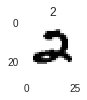

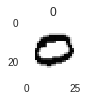

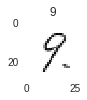

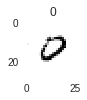

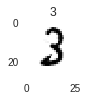

In [9]:
# answers
x_test = test_set.values.reshape(len(test_set), 28, 28, 1)
x_test = x_test / 255
y_answer = model.predict(x_test)
y_answer = np.argmax(y_answer, axis=1)
print(y_answer.shape)

for x_eg, y_eg in zip(test_set.values[:5, :], y_answer[:5]):
    plot_number(x_eg, y_eg)

In [10]:
answer_df = pd.DataFrame(
    y_answer,
    index=list(range(1, len(y_answer)+1)),
    columns=['Label']
)
answer_df.index.name = 'ImageId'

print(answer_df.info())
display(answer_df.head())

answer_df.to_csv('data/kaggle_mnist/submission.csv', index=True, header=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 28000 entries, 1 to 28000
Data columns (total 1 columns):
Label    28000 non-null int64
dtypes: int64(1)
memory usage: 437.5 KB
None


,Label
ImageId,
1,2
2,0
3,9
4,0
5,3
